In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('data/demographic.csv')
df2 = pd.read_csv('data/questionnaire.csv')

df = pd.concat([df1, df2], axis=1, join='inner')

df.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520
0,73557,8,2,1,69,NaN,4,4,1.0,NaN,...,NaN,40.0,270.0,200.0,69.0,270.0,62.0,NaN,NaN,NaN
1,73558,8,2,1,54,NaN,3,3,1.0,NaN,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN
2,73559,8,2,1,72,NaN,3,3,2.0,NaN,...,NaN,NaN,180.0,190.0,70.0,228.0,35.0,NaN,NaN,NaN
3,73560,8,2,1,9,NaN,3,3,1.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0
4,73561,8,2,2,73,NaN,3,3,1.0,NaN,...,NaN,NaN,150.0,135.0,67.0,170.0,60.0,NaN,NaN,NaN


In [3]:
print('Shape of DataFrame with all data: ', df.shape)
df1 = df.loc[(df.RIDAGEYR >= 20)]
df2 = df1#[df1.columns[df1.isna().sum() < 1000]]
print('Shape of DataFrame with only 20 year olds and older: ', df2.shape)

Shape of DataFrame with all data:  (10175, 1000)
Shape of DataFrame with only 20 year olds and older:  (5769, 1000)


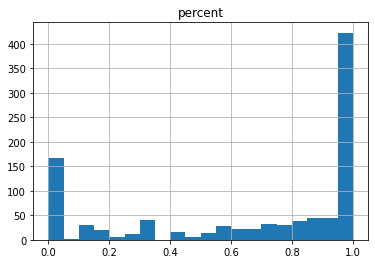

In [4]:
nas=pd.DataFrame(df2.isnull().sum().sort_values(ascending=False)/len(df2),columns = ['percent'])
pos = nas['percent'] > 0
nas[pos]
nas.hist(bins = 20)
acceptable_feats = nas.loc[nas['percent'] < 0.2]
list_acceptable_feats = list(acceptable_feats.index)

In [5]:
c = df2[list_acceptable_feats].corr().abs()
dc = c['DIQ010'].dropna().sort_values(kind="quicksort", ascending=False)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(dc)

DIQ010      1.000000
DIQ160      0.366512
DIQ050      0.339186
MCQ365D     0.178347
RIDAGEYR    0.172404
MCQ365B     0.168830
MCQ365A     0.165470
PFQ054      0.162203
MCQ365C     0.161068
HUQ010      0.153170
HSD010      0.152896
DMDHRAGE    0.140637
BPQ020      0.139976
OCD150      0.133159
DMDHHSZE    0.130109
PFQ090      0.124808
SMQ856      0.121996
DLQ050      0.119412
PFQ051      0.118122
BPQ059      0.117956
MCQ080      0.113365
PFQ049      0.104978
HUQ071      0.097400
INQ030      0.094678
BPQ056      0.090759
BPQ080      0.089642
DLQ060      0.088389
PAQ650      0.084093
DMDEDUC2    0.083897
HUQ030      0.082702
MCQ160E     0.082323
DLQ020      0.081753
PFQ057      0.080428
PAQ715      0.079234
MCQ370C     0.078360
MCQ160A     0.078199
DLQ080      0.073203
DLQ010      0.072886
WTINT2YR    0.071819
INQ020      0.071037
MCQ370D     0.069488
MCQ300C     0.068719
OHQ033      0.067820
MCQ160L     0.067401
WTMEC2YR    0.065873
HUQ020      0.064862
MCQ160N     0.063509
WHQ030      0

In [6]:
df3 = df2[list_acceptable_feats]
df3 = df3[df3['DIQ010'].notna()]

In [ ]:
#feature creation for has smoked and drank
new_col = []
for row_num in range(df3.shape[0]):
    if df3.iloc[row_num]['ALQ101'] == 1 and df3.iloc[row_num]['SMQ020'] == 1:
        new_col.append(1)
    else:
        new_col.append(0)
smoke_drink = pd.Series(new_col)
if 'smoke_drink' not in df3.columns:
    df3.insert(0, "smoke_drink", smoke_drink)
df3.head()

#feature creation for takeout/groceries
new_col = []
for row_num in range(df3.shape[0]):
    if (df3.iloc[row_num]['CBD070'] != (999999) and df3.iloc[row_num]['CBD070'] != (777777)) and (df3.iloc[row_num]['CBD130'] != (999999) and df3.iloc[row_num]['CBD130'] != (777777)):
        new_col.append(df3.iloc[row_num]['CBD130']/(df3.iloc[row_num]['CBD070']+0.01))
    else:
        new_col.append(np.nan)
takeout_groceries = pd.Series(new_col)
if 'takeout_groceries' not in df3.columns:
    df3.insert(0, "takeout_groceries", takeout_groceries)
df3.head()
df3['takeout_groceries'].max()

In [ ]:
from sklearn.impute import KNNImputer
import time

tic = time.time()

col_names = list(df3.columns)

print('Before imputation: ', df3.isnull().sum().sum(), 'missing')

#fill na's with medians
#for col in df3.columns:
#    df3[col] = df3[col].fillna((df3[col].median()))
    
#fill na's using KNN
imputer = KNNImputer(n_neighbors=3)
df3 = pd.DataFrame(imputer.fit_transform(df3))
      
print('After imputation: ', df3.isnull().sum().sum(), 'missing')

df3.columns = col_names

toc = time.time()
print('runtime: ',toc-tic)

In [ ]:
print('Shape of DataFrame before dropping unwanted features: ', df3.shape)
remove_list = ['DIQ160', 'DIQ050', 'DIQ180', 'DIQ172', 'DIQ170', 'SLQ060', 'SIAPROXY', 'HUQ010', 'HUQ010', 'DMDHRAGE', 'DLQ060', 'RIDAGEYR', 'DLQ050', 'WTINT2YR', 'WTMEC2YR']
keep_list = set(df3.columns) - set(remove_list)
df3 = df3[keep_list]
prefix_list = ['MCQ','HUQ','BPQ','PFQ','DLQ','HSD', 'OHQ', 'WHQ', 'SEQN', 'DPQ', 'HIQ', 'HSQ', 'WHD', 'DMD', 'DBQ']
df3 = df3.loc[:,~df3.columns.str.startswith(tuple(prefix_list))]
print('Shape of DataFrame after dropping unwanted features: ', df3.shape)

c1 = df3.corr().abs()
dc1 = c1['DIQ010'].dropna().sort_values(kind="quicksort", ascending=False)

df4 = df3[list(dc1.index)[:31]]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(dc1)

In [ ]:
from sklearn import preprocessing

X = df4.drop('DIQ010', 1)
y = df4['DIQ010']

#Dummy variables
dummy_list = []
for col in df4.drop('DIQ010', 1).columns:
    if df4[col].max() <= 99:
        dummy_list.append(col)
X = pd.get_dummies(X, prefix=dummy_list, columns=dummy_list)

# Here we use the StandardScaler() method of the preprocessing package, and then call the fit() method with parameter X 
scaler = preprocessing.StandardScaler().fit(X)

# Declare a variable called X_scaled, and assign it the result of calling the transform() method with parameter X 
X_scaled=scaler.transform(X)

In [ ]:
from sklearn.model_selection import train_test_split

# Get the 1-dimensional flattened array of our response variable y by calling the ravel() function on y
y = y.ravel()

# Call the train_test_split() function with the first two parameters set to X_scaled and y 
# Declare four variables, X_train, X_test, y_train and y_test separated by commas 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=1)

In [ ]:
import time
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

tic = time.time()

# Initialize our classifier
clf = RandomForestClassifier(max_depth=100, n_estimators=50, max_features=50)

# Train our classifier
model = clf.fit(X_train, y_train)

# Make predictions
preds = clf.predict(X_test)
print(preds)

# Evaluate accuracy
print(accuracy_score(y_test, preds))

toc = time.time()
print('runtime: ',toc-tic)